In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

In [2]:
df_final = pd.read_pickle('../data/processed_student_data.pkl')

In [3]:
X = df_final.drop(columns=["label", "id_student"])
y = df_final["label"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [6]:
model_lr = LogisticRegression(solver='liblinear', class_weight='balanced',  max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [7]:
y_pred = model_lr.predict(X_test_scaled) # Make predictions

In [8]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAUC Score:", roc_auc_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]))

Confusion Matrix:
 [[3480 1008]
 [ 449 1582]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      4488
           1       0.61      0.78      0.68      2031

    accuracy                           0.78      6519
   macro avg       0.75      0.78      0.76      6519
weighted avg       0.80      0.78      0.78      6519


AUC Score: 0.8534970655376425


Recall = 0.78 shows that it is better at catching dropouts(1)

Precision is lower which means, predicts more false positives


In [9]:
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4488
           1       0.75      0.57      0.65      2031

    accuracy                           0.81      6519
   macro avg       0.79      0.74      0.76      6519
weighted avg       0.80      0.81      0.80      6519

AUC: 0.8694599790589885


The above reprort shows us that the RF model is more confident in predicting dropouts due to higer precision.

Misses actual dropouts as recall = 0.57, risky in real world cases

Logic Regression more appropriate here

Next step involves Model Interpretability and Feature Importance

In [11]:
importances = rf.feature_importances_
features = X_train.columns

In [12]:
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False)

/tmp/ipykernel_2780/3425856341.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', legend=False, palette='viridis')


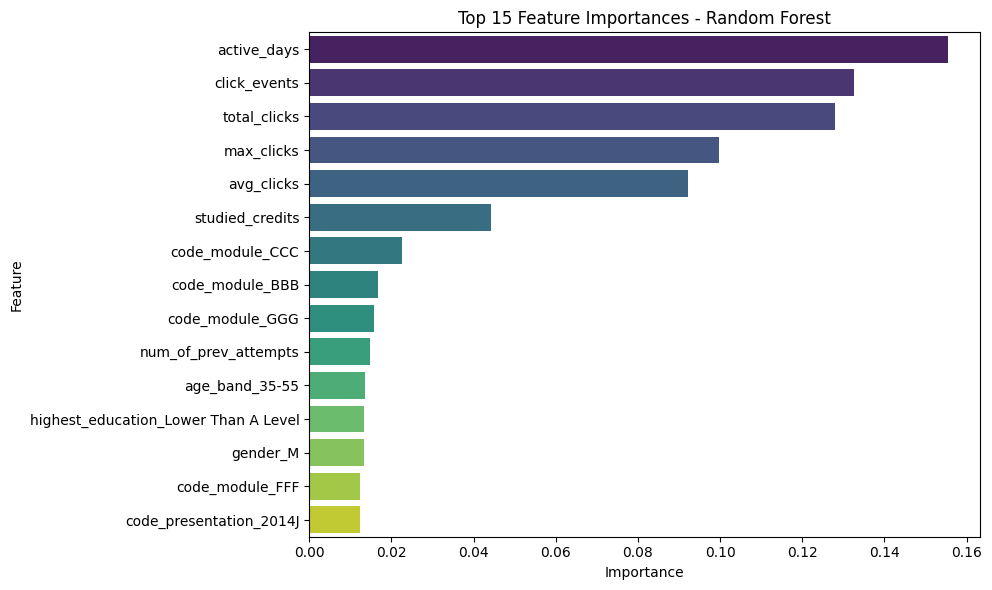

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', legend=False, palette='viridis')
plt.title("Top 15 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

In [14]:
explainer = shap.TreeExplainer(rf)
X_sample = X_train.sample(n=1000, random_state=42)  
shap_values = explainer.shap_values(X_sample)

In [15]:
print("shap_values type:", type(shap_values))
print("len(shap_values):", len(shap_values))
print("shap_values[1] shape:", shap_values[1].shape)

shap_values type: <class 'numpy.ndarray'>
len(shap_values): 1000
shap_values[1] shape: (45, 2)


In [16]:
print(shap_values.shape)

(1000, 45, 2)


In [17]:
shap_values_class1 = shap_values[:, :, 1] #class 1 Dropout

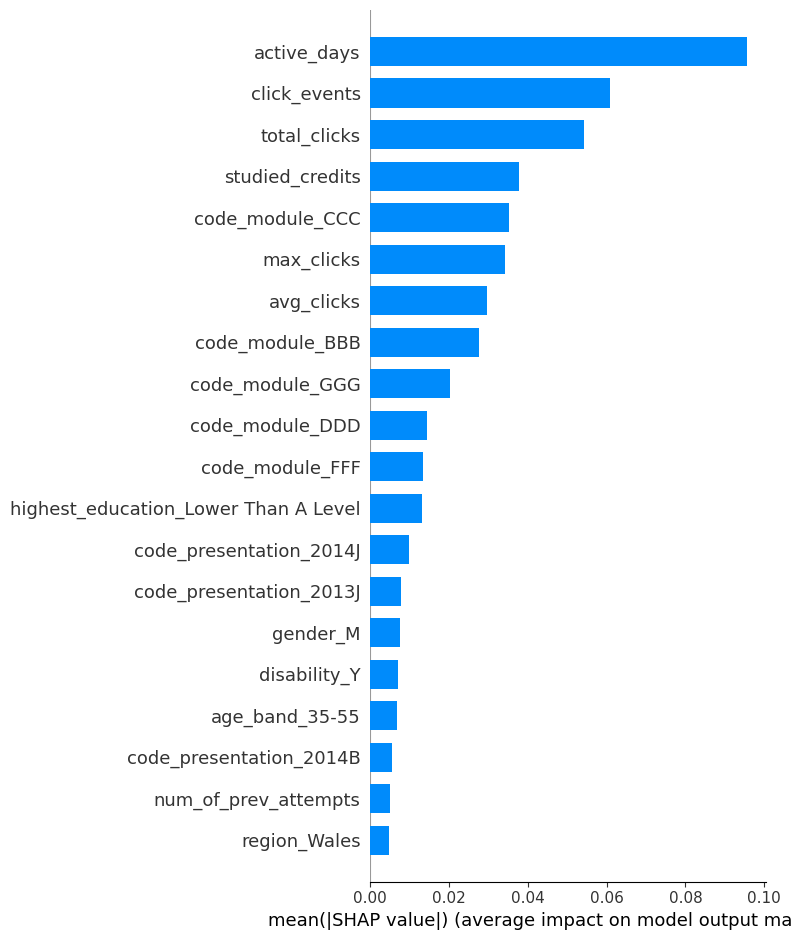

In [18]:
shap.summary_plot(shap_values_class1, X_sample, plot_type="bar")

The above bar plot ranks features by average impact on dropour prediction. active_days, click_events and total_clicks are some of the key behavioural features from the plot. The main takeaway here is that, the model relies most on how active students are in the platform.

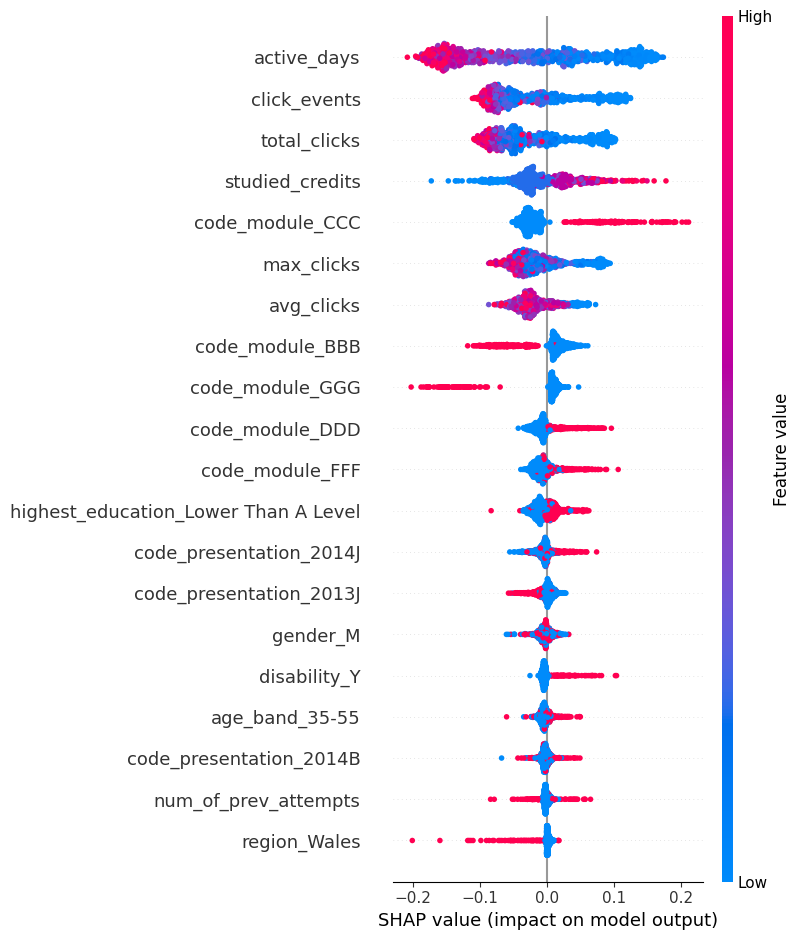

In [19]:
shap.summary_plot(shap_values_class1, X_sample)

The above Beeswarm plot shows impact by value. Each dot reperesents one student. Blue means low feature value and Pink is high. 

Students with fewer active days (blue, left side) are more likely to dropout.

Higher total_clicks shift predictions toward not dropping out (pink, right side).

In [22]:
# Save Random Forest model
joblib.dump(rf, '../models/random_forest_model.pkl')

['../models/random_forest_model.pkl']

In [23]:
# Save the trained model
joblib.dump(model_lr, '../models/dropout_model.pkl')

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']